In [1]:
from pathlib import Path
import subprocess

REPO_URL = "https://github.com/seoultechpse/fenicsx-colab.git"
ROOT = Path("/content")
REPO_DIR = ROOT / "fenicsx-colab"

subprocess.run(["git", "clone", REPO_URL, str(REPO_DIR)], check=True)

USE_COMPLEX = False  # <--- Set True ONLY if you need complex PETSc
USE_CLEAN = False    # <--- Set True to remove existing environment

opts_str = " ".join(
  [o for c, o in [(USE_COMPLEX, "--complex"), (USE_CLEAN, "--clean")] if c]
)

get_ipython().run_line_magic("run", f"{REPO_DIR / 'setup_fenicsx.py'} {opts_str}")

🔧 FEniCSx Setup Configuration
PETSc type      : real
Clean install   : False

⚠️  Google Drive not mounted — using local cache (/content)

🔧 Installing FEniCSx environment...

🔍 Verifying PETSc type...
✅ Installed: Real PETSc (float64)

✨ Loading FEniCSx Jupyter magic... %%fenicsx registered

✅ FEniCSx setup complete!

Next steps:
  1. Run %%fenicsx --info to verify installation
  2. Use %%fenicsx in cells to run FEniCSx code
  3. Use -np N for parallel execution (e.g., %%fenicsx -np 4)

📌 Note: Real PETSc is installed
   - Recommended for most FEM problems
   - For complex problems, reinstall with --complex


---

In [4]:
%%fenicsx

import numpy as np
import basix
import basix.ufl
import matplotlib.pyplot as plt

# Reference Lattice
reference_points = basix.create_lattice(
    basix.CellType.triangle, 8,
    basix.LatticeType.gll,
    exterior=False,
    method=basix.LatticeSimplexMethod.warp
)
print(f"{reference_points.shape = }\n")

# Mapping Reference → Physical Triangle
def compute_physical_point(p0, p1, p2, X):
    el = basix.ufl.element("Lagrange", "triangle", 1)
    phi = el.tabulate(0, X)[0]
    return phi @ np.vstack([p0, p1, p2])

p0 = np.array([2.0, 1.8])
p1 = np.array([1.0, 1.2])
p2 = np.array([1.3, 1.0])

x = compute_physical_point(p0, p1, p2, reference_points)

print(f"{p0 = }")
print(f"{p1 = }")
print(f"{p2 = }\n")
print(f"{x[:5] = }\n")

# Jacobian Computation

X = basix.create_lattice(
    basix.CellType.triangle, 8,
    basix.LatticeType.equispaced, exterior=True
)

# Compute physical points for X (not just reference_points)
x_for_viz = compute_physical_point(p0, p1, p2, X)

el = basix.ufl.element("Lagrange", "triangle", 1)
dphi = el.tabulate(1, X)[1:]
points = np.vstack([p0, p1, p2])

dxdX = dphi[0] @ points
dydX = dphi[1] @ points

J = np.transpose(
    np.hstack([dxdX, dydX]).reshape(len(X), 2, 2),
    (0, 2, 1)
)

print(f"{X.shape = }")
print(f"{x_for_viz.shape = }\n")
print(f"{J[0] = }\n")

# Inverse Jacobian
J_inv_T = np.transpose(np.linalg.inv(J), (0, 2, 1))

print(f"{J_inv_T[0] = }\n")

# Nédélec Elements and Piola Map
ned = basix.ufl.element("N1curl", "triangle", 1)

ref_basis = ned.tabulate(0, X)[0].reshape(len(X), 2, ned.dim)

phys_basis = np.zeros_like(ref_basis)
for i in range(len(X)):
    phys_basis[i] = J_inv_T[i] @ ref_basis[i]

print(f"{ref_basis.shape = }")
print(f"{phys_basis.shape = }\n")

# Visualization
# Create color map for better visualization
theta = 2 * np.pi
phi_angle = np.linspace(0, theta, len(X))
rgb_cycle = (
    np.stack((np.cos(phi_angle),
              np.cos(phi_angle - theta / 4),
              np.cos(phi_angle + theta / 4))).T + 1
) * 0.5

# Get reference triangle vertices for plotting
ref_vertices = basix.cell.geometry(basix.CellType.triangle)
phys_vertices = np.vstack([p0, p1, p2])

for i in range(ned.dim):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Reference element
    ref_triangle = plt.Polygon(ref_vertices, facecolor='lightblue', alpha=0.2, edgecolor='blue', linewidth=2)
    ax[0].add_patch(ref_triangle)
    ax[0].scatter(X[:,0], X[:,1], c=rgb_cycle, s=30, zorder=3)
    ax[0].quiver(X[:,0], X[:,1],
                 ref_basis[:,0,i], ref_basis[:,1,i],
                 angles='xy', scale_units='xy', scale=12,
                 color='red', width=0.005)
    ax[0].set_title(f"Reference $\\phi_{i}$", fontsize=14, fontweight='bold')
    ax[0].set_aspect("equal")
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].grid(True, alpha=0.3)
    ax[0].set_xlim(-0.1, 1.1)
    ax[0].set_ylim(-0.1, 1.1)

    # Physical element
    phys_triangle = plt.Polygon(phys_vertices, facecolor='lightgreen', alpha=0.2, edgecolor='green', linewidth=2)
    ax[1].add_patch(phys_triangle)
    ax[1].scatter(x_for_viz[:,0], x_for_viz[:,1], c=rgb_cycle, s=30, zorder=3)
    ax[1].quiver(x_for_viz[:,0], x_for_viz[:,1],
                 phys_basis[:,0,i], phys_basis[:,1,i],
                 angles='xy', scale_units='xy', scale=12,
                 color='red', width=0.005)
    ax[1].set_title(f"Physical $\\mathcal{{F}}\\phi_{i}$", fontsize=14, fontweight='bold')
    ax[1].set_aspect("equal")
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    ax[1].grid(True, alpha=0.3)
    ax[1].set_xlim(0.9, 2.1)
    ax[1].set_ylim(0.9, 2.1)

    plt.tight_layout()

    # Save figure
    filename = f"nedelec_basis_{i}.png"
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Saved: {filename}")

    plt.close()  # Close to free memory

print("\n✅ Visualization complete!")
print(f"Total basis functions plotted: {ned.dim}")
print(f"Points per element: {len(X)}")
print(f"\nAll figures saved as: nedelec_basis_0.png, nedelec_basis_1.png, nedelec_basis_2.png")



reference_points.shape = (21, 2)

p0 = array([2. , 1.8])
p1 = array([1. , 1.2])
p2 = array([1.3, 1. ])

x[:5] = array([[1.88016284, 1.70131057],
       [1.74326098, 1.61392435],
       [1.57254782, 1.50884806],
       [1.39094625, 1.39988711],
       [1.22302087, 1.30178028]])

X.shape = (45, 2)
x_for_viz.shape = (45, 2)

J[0] = array([[-1. , -0.7],
       [-0.6, -0.8]])

J_inv_T[0] = array([[-2.10526316,  1.57894737],
       [ 1.84210526, -2.63157895]])

ref_basis.shape = (45, 2, 3)
phys_basis.shape = (45, 2, 3)

Saved: nedelec_basis_0.png
Saved: nedelec_basis_1.png
Saved: nedelec_basis_2.png

✅ Visualization complete!
Total basis functions plotted: 3
Points per element: 45

All figures saved as: nedelec_basis_0.png, nedelec_basis_1.png, nedelec_basis_2.png


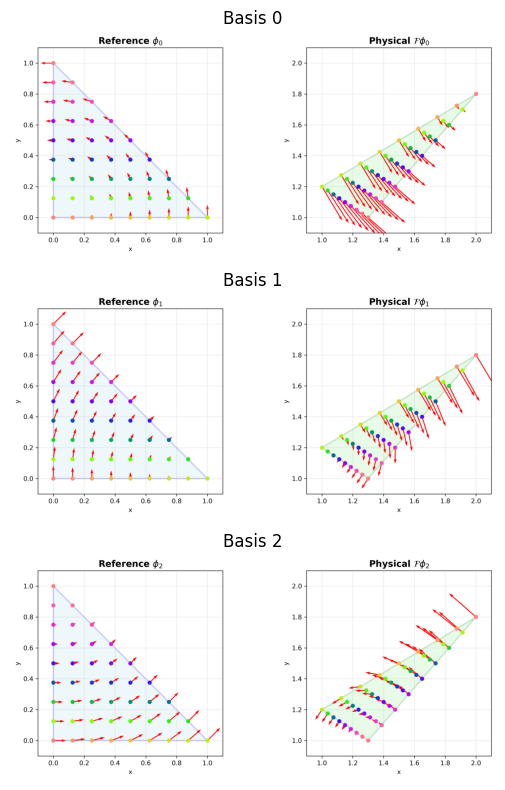

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axes = plt.subplots(3, 1, figsize=(6, 8))
for i in range(3):
    img = mpimg.imread(f'nedelec_basis_{i}.png')
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Basis {i}', fontsize=12)
plt.tight_layout()
plt.show()

---

# Maxwell Equation FEM Example (FEniCSx)
## H(curl) formulation with Nédélec elements

This notebook demonstrates a **2D time-harmonic Maxwell problem** using **Nédélec (N1curl) elements**, directly extending the workshop material.

## Problem Statement
We solve the curl–curl problem:

$$\nabla \times (\nabla \times \mathbf{E}) + k^2 \mathbf{E} = \mathbf{f} \quad \text{in } \Omega$$

with perfectly conducting boundary conditions:

$$\mathbf{n} \times \mathbf{E} = 0 \quad \text{on } \partial\Omega$$

In [21]:
%%fenicsx

import numpy as np
from mpi4py import MPI
from petsc4py import PETSc

from dolfinx import mesh, fem, io
from dolfinx.fem.petsc import LinearProblem

import ufl

# Create mesh
domain = mesh.create_unit_square(MPI.COMM_WORLD, 32, 32)

# Nédélec H(curl) space
V = fem.functionspace(domain, ("N1curl", 1))

print(f"Number of DOFs: {V.dofmap.index_map.size_global}")
print(f"Mesh dimension: {domain.topology.dim}")

# ========================================
# Tangential Dirichlet BC: n × E = 0
# ========================================
# For Nédélec elements, we need to use facet-based BC

# Identify boundary facets
tdim = domain.topology.dim
fdim = tdim - 1  # Facet dimension (edges in 2D)

domain.topology.create_connectivity(fdim, tdim)

# Find all boundary facets
boundary_facets = mesh.exterior_facet_indices(domain.topology)

print(f"Number of boundary facets: {len(boundary_facets)}")

# Locate DOFs on boundary facets
boundary_dofs = fem.locate_dofs_topological(V, fdim, boundary_facets)

print(f"Number of boundary DOFs: {len(boundary_dofs)}")

# Create zero boundary condition
u_bc = fem.Function(V)
u_bc.x.array[:] = 0.0

bc = fem.dirichletbc(u_bc, boundary_dofs)

# ========================================
# Variational Formulation
# ========================================
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

k = 10.0

# Source term
f = fem.Function(V)
f.interpolate(lambda x: np.vstack((
    np.sin(np.pi * x[1]),
    np.sin(np.pi * x[0])
)))

# Weak form: (curl u, curl v) + k² (u, v) = (f, v)
a = (
    ufl.inner(ufl.curl(u), ufl.curl(v))
    + k**2 * ufl.inner(u, v)
) * ufl.dx

L = ufl.inner(f, v) * ufl.dx

# ========================================
# Solve Linear System
# ========================================
problem = LinearProblem(
    a, L, bcs=[bc],
    petsc_options={
        "ksp_type": "cg",
        "pc_type": "hypre",
        "ksp_rtol": 1e-8
    },
    petsc_options_prefix="maxwell_"
)

E = problem.solve()

print(f"\n✅ Solution computed successfully!")
print(f"Solution norm: {np.linalg.norm(E.x.array):.6e}")

# ========================================
# Compute curl of solution
# ========================================
# For 2D, curl E is a scalar (z-component)
curl_E_expr = ufl.curl(E)

# Create DG space for visualization
DG = fem.functionspace(domain, ("DG", 0))
curl_E = fem.Function(DG, name="Curl_E")

# Project curl onto DG space
curl_E_expr = fem.Expression(curl_E_expr, DG.element.interpolation_points)
curl_E.interpolate(curl_E_expr)

print(f"Curl norm: {np.linalg.norm(curl_E.x.array):.6e}")

# ========================================
# Save results
# ========================================
# VTXWriter only supports (Discontinuous) Lagrange elements
# We need to interpolate Nédélec function to DG space

# Create DG vector space for electric field
DG_vec = fem.functionspace(domain, ("DG", 1, (domain.geometry.dim,)))
E_dg = fem.Function(DG_vec, name="ElectricField")

# Interpolate E to DG space
E_expr = fem.Expression(E, DG_vec.element.interpolation_points)
E_dg.interpolate(E_expr)

# Save solution
with io.VTXWriter(domain.comm, "maxwell_results.bp", [E_dg, curl_E]) as vtx:
    vtx.write(0.0)

print("\n📁 Results saved:")
print("  - maxwell_results.bp - Electric field E interpolated to DG, curl of E")

# ========================================
# Compute energy
# ========================================
# Total energy = ∫(|curl E|² + k²|E|²) dx
curl_energy = fem.assemble_scalar(fem.form(ufl.inner(ufl.curl(E), ufl.curl(E)) * ufl.dx))
field_energy = fem.assemble_scalar(fem.form(ufl.inner(E, E) * ufl.dx))
total_energy = curl_energy + k**2 * field_energy

print(f"\n⚡ Energy Analysis:")
print(f"  Curl energy:  {curl_energy:.6e}")
print(f"  Field energy: {field_energy:.6e}")
print(f"  Total energy: {total_energy:.6e}")

# ========================================
# Alternative: Specify BC on specific boundaries
# ========================================
print("\n" + "="*60)
print("Alternative: Apply BC only on specific boundaries")
print("="*60)

def boundary_left(x):
    return np.isclose(x[0], 0.0)

def boundary_right(x):
    return np.isclose(x[0], 1.0)

def boundary_bottom(x):
    return np.isclose(x[1], 0.0)

def boundary_top(x):
    return np.isclose(x[1], 1.0)

# Example: BC only on left and right boundaries
left_facets = mesh.locate_entities_boundary(domain, fdim, boundary_left)
right_facets = mesh.locate_entities_boundary(domain, fdim, boundary_right)
lr_facets = np.concatenate([left_facets, right_facets])

boundary_dofs_lr = fem.locate_dofs_topological(V, fdim, lr_facets)

print(f"DOFs on left/right boundaries: {len(boundary_dofs_lr)}")

# You can create different BCs:
# bc_lr = fem.dirichletbc(u_bc, boundary_dofs_lr)
# Then solve with bcs=[bc_lr] instead of bcs=[bc]

print("\n✅ Complete!")

Number of DOFs: 3136
Mesh dimension: 2
Number of boundary facets: 128
Number of boundary DOFs: 128

✅ Solution computed successfully!
Solution norm: 1.526115e-02
Curl norm: 1.294173e+00

📁 Results saved:
  - maxwell_results.bp - Electric field E interpolated to DG, curl of E

⚡ Energy Analysis:
  Curl energy:  8.178141e-04
  Field energy: 8.290206e-05
  Total energy: 9.108020e-03

Alternative: Apply BC only on specific boundaries
DOFs on left/right boundaries: 64

✅ Complete!


In [22]:
!zip -r maxwell_results.zip maxwell_results.bp

from google.colab import files

files.download('maxwell_results.zip')

  adding: maxwell_results.bp/ (stored 0%)
  adding: maxwell_results.bp/mmd.0 (deflated 64%)
  adding: maxwell_results.bp/md.idx (deflated 59%)
  adding: maxwell_results.bp/data.0 (deflated 75%)
  adding: maxwell_results.bp/profiling.json (deflated 62%)
  adding: maxwell_results.bp/md.0 (deflated 76%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>